# Data analysis project : Energy

Written by Julien Samuel, Mayuxiang Chen and Jolan Kerrien

In [1]:
import numpy as np
from scipy import stats
import pandas as pd

#Ploting librairies:
import matplotlib.pyplot as plt
import seaborn as sns

#linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error #r2_score

## 1) Graphical Representation of all the variables with respect to the target + Computing the correlation

Julien

In [2]:
# Importation of the data 
df = pd.read_csv('energy_data.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,North,0.0,type1,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,South,0.0,type1,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,Est,0.0,type1,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,West,0.0,type1,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,North,0.0,type1,20.84,28.28


Correspondance of the variable
- X1 Relative Compactness
- X2 Surface Area
- X3 Wall Area
- X4 Roof Area
- X5 Overall Height
- X6 Orientation
- X7 Glazing Area
- X8 Glazing Area Distribution

Functions that will help us through our analysis

In [3]:
def identify_missing(data): 
    ''' Identify the features missing values NaN
    Return list of features with the number of missing values 
    input = dataframe and print dataframe '''
    missing = data.isnull().sum()
    missing_result = pd.DataFrame(missing).reset_index().rename(columns = {'index' : 'features', 0 :'missing_nbr'})
    missing_result['missing_fraction']=(missing_result.missing_nbr/data.shape[0])*100
    print(missing_result)
    
def information_about_data(data): 
    '''numeric features : get the min and the max
       categorical features get the nbr of classes
       input = a dataframe and prints statistics of columns of this dataframe'''
    print(" ")
    print("Numerical features")
    for col in data.columns : 
        if data[col].dtype != 'object' :
            print('The feature "%s" have a minimum value of %s and a maximum value of %s' % (col,data[col].min(), data[col].max()))

    print(" ")
    print("Categorical features")
    for col in data.columns : 
        if data[col].dtype == 'object' :
            print('The feature "%s" have %s unique values which are %s' % (col,len(data[col].unique()),data[col].unique()))
            
def Plot(df,Y_value):
    for i in [1,2,3,4,5,7]:
        plt.plot(df[f'X{i}'],df[f'Y{Y_value}'],'.',label = f'Y{Y_value} (X{i})')
        plt.legend()
        plt.show()
    

In [4]:
identify_missing(df)

  features  missing_nbr  missing_fraction
0       X1            0               0.0
1       X2            0               0.0
2       X3            0               0.0
3       X4            0               0.0
4       X5            0               0.0
5       X6            0               0.0
6       X7            0               0.0
7       X8            0               0.0
8       Y1            0               0.0
9       Y2            0               0.0


There is no missing numbers in our data, so no need to think about a way to replace them

In [5]:
information_about_data(df)

 
Numerical features
The feature "X1" have a minimum value of 0.62 and a maximum value of 0.98
The feature "X2" have a minimum value of 514.5 and a maximum value of 808.5
The feature "X3" have a minimum value of 245.0 and a maximum value of 416.5
The feature "X4" have a minimum value of 110.25 and a maximum value of 220.5
The feature "X5" have a minimum value of 3.5 and a maximum value of 7.0
The feature "X7" have a minimum value of 0.0 and a maximum value of 0.4
The feature "Y1" have a minimum value of 6.01 and a maximum value of 43.1
The feature "Y2" have a minimum value of 10.9 and a maximum value of 48.03
 
Categorical features
The feature "X6" have 4 unique values which are ['North' 'South' 'Est' 'West']
The feature "X8" have 6 unique values which are ['type1' 'type2' 'type3' 'type4' 'type5' 'type6']


### Tracer des $X_i$ en fonction de $Y_1$ puis $Y_2$

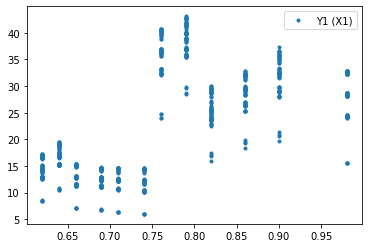

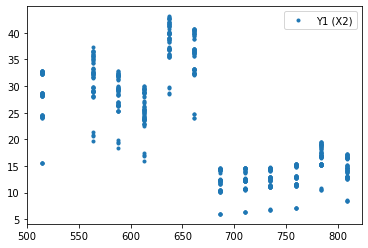

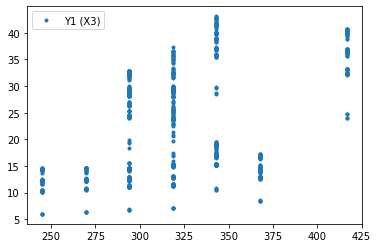

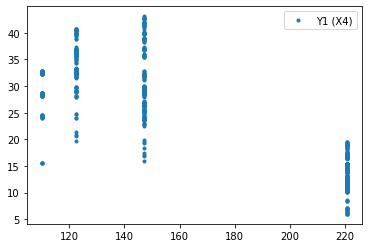

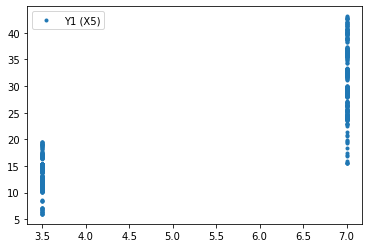

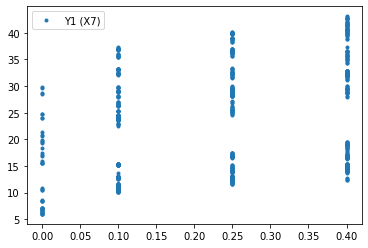

In [6]:
Plot(df,1)

We notice that all the plots are non-monotonous non-linear non-polynomials with very low or even null intensities.

We also computed the correlation between all the __numerical variables__ in a heatmap :

<AxesSubplot:>

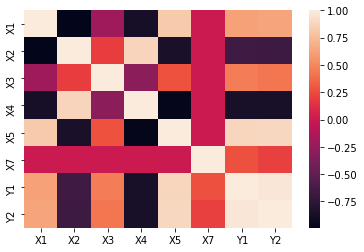

In [7]:
def heatmap(df):
    df_new = df.copy()
    data = pd.DataFrame(df_new, columns=['X1','X2','X3','X4','X5','X6','X7','X8','Y1','Y2'])
    del data['X6']
    del data['X8']
    return sns.heatmap(data.corr())

heatmap(df)

First of all, we notice that the __glazing area X7__ and the __wall area X3__ have __very low correlation__ with all the other variables.

The __roof area X4__ and the __surface area X2__ both have very __high correlation__ with the __heating and cooling loads Y1 and Y2__ respectively, as well as the __overall height X5__ and the __relative compactness X1__.

Also, it is clear that __Y1__ and __Y2__ have a __strong correlation__ with one another.

## 2) Transformation of the categorical variables

Julien

We must transform the 2 categorical variables which are $X_6$ (the orientation) and $X_8$ (the glazing area distribution) into numerical variables.

Firstly, we plot $X_6$ and $X_8$ against $Y_1$ in a histogram :

In [8]:
#plot distribution between a categorical value and a numerical value in an histogram via predefined function
def plot_figure_num(x_var,groupby_var,w,h, nbr_bins,x_min, x_max,step_x,df,colors):
    '''input : name of numerical variable , name of categorical variable ,width,height, 
               nbr_bins,x_min numeric, x_max numeric,step_x to show ,dataframe'''
    #x_var = 'hours-per-week'
    #groupby_var = 'income'
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]
    plt.figure(figsize=(w,h))
    n, bins, patches = plt.hist(vals, nbr_bins, stacked=True, color=colors[:len(vals)], edgecolor = 'black') 
    plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.xlabel(x_var)
    plt.ylabel("count")
    plt.xticks(np.arange(x_min, x_max, step=step_x))
    plt.title(x_var + ' distribution in function of ' + groupby_var)
    plt.show()

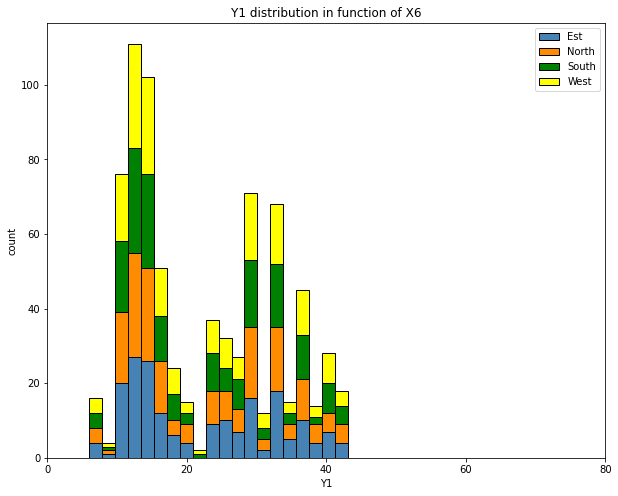

In [9]:
plot_figure_num('Y1','X6',10,8, 20,0, 100,20,df,['steelblue','darkorange','green','yellow'])

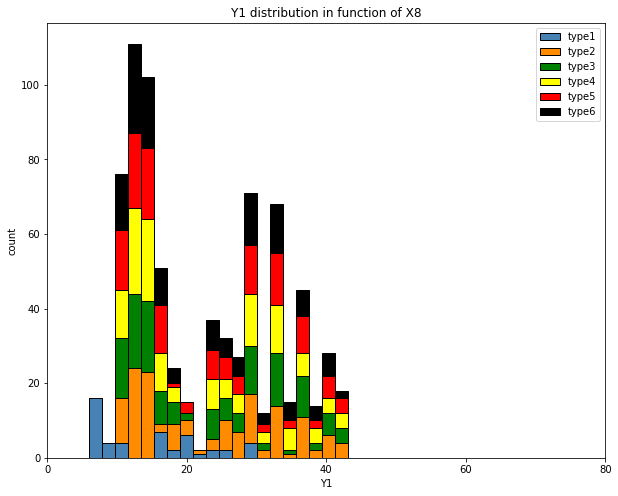

In [10]:
plot_figure_num('Y1','X8',10,8, 20,0, 100,20,df,['steelblue','darkorange','green','yellow','red','black'])

We can see that the plots are non-monotoneous non-linear polynomials.

### Transformation of the variable

The orientation $X_6$ has 4 distinct value : North, South, West and East. 
Therefore it can be transformed by replacing the $X_6$ column by 3 new columns:

North : 1 or 0

South : 1 or 0

West : 1 or 0

Where 1 means yes and 0 means no, also if all 3 columns have 0 values it means the direction is East.

The glazing area distribution $X_8$ has 6 distinct values : type 1, type 2, type 3, type 4, type 5 and type 6.
So, it can be transformed into :

type 1 : 1  

type 2 : 2  

type 3 : 3

type 4 : 4

type 5 : 5

type 6 : 6

In [11]:
def transfX6(df):
    df_new = df.copy()
    df_new.insert(6,'North', (df['X6']== 'North').astype(int))
    df_new.insert(7,'South', (df['X6']== 'South').astype(int))
    df_new.insert(8,'West', (df['X6']== 'West').astype(int))
    del df_new['X6']
    return df_new

def transfX8(df):
    df_new = df.copy()
    list = {"X8" : {"type1":1, "type2":2, "type3":3, "type4":4, "type5":5, "type6":6}}
    df_new = df_new.replace(list)
    return df_new

In [12]:
X6_num = transfX6(df)
X8_num = transfX8(df)

df1 = pd.DataFrame(X6_num)
df2 = pd.DataFrame(X8_num)
df1['X8']=df2['X8']

df_num = df1.copy()
df_num.head()

,X1,X2,X3,X4,X5,North,South,West,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,1,0,0,0.0,1,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,0,1,0,0.0,1,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,0,0,0,0.0,1,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,0,0,1,0.0,1,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,1,0,0,0.0,1,20.84,28.28


In [13]:
## Stats with the numerical values
stat = pd.DataFrame()
stat['mean'] = df_num.mean()
stat['Var'] = df_num.var()
stat['Std.Var'] = df_num.std()
stat

,mean,Var,Std.Var
X1,0.764167,0.011189,0.105777
X2,671.708333,7759.163842,88.086116
X3,318.500000,1903.269883,43.626481
X4,176.604167,2039.963060,45.165950
X5,5.250000,3.066493,1.751140
North,0.250000,0.187744,0.433295
South,0.250000,0.187744,0.433295
West,0.250000,0.187744,0.433295
X7,0.234375,0.017748,0.133221
X8,3.812500,2.405476,1.550960


<AxesSubplot:>

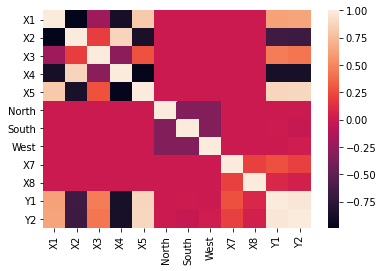

In [14]:
def heatmap2(df_num):
    df_new = df_num.copy()
    data = pd.DataFrame(df_new, columns=['X1','X2','X3','X4','X5','North','South','West','X7','X8','Y1','Y2'])
    return sns.heatmap(data.corr())

heatmap2(df_num)

The main difference of this heatmap with the previous one is that, obviously, we added X6 and X8. 

We can see that the variables of the direction only have correlations with each other. Also, the glazing area distribution X8 has 0 correlation with X1, X2, X3, X4, X5 and all the directions but has a small correlation with the glazing area X7, Y1 and Y2.

## 3) Normalize variables

Mayuxiang

In order to make the data easier to understand and analyze, the normalization is inevitable.The purpose of this part of work is to atrribute the same importance to the different data, and appropriatle change some values, since the bigger values generally have greater influence in the cases. Hence, there have been two methoded are proposed to normalize variables.
(1) Min-max feature: (X-Xmin)/(Xmax-Xmin)
(2) Standard score method: (X - Xave)/standard deviation
Min-max feature can chage all the value between 0 and 1, so it is also called as unity based normalization. Standard score method is usually applied when the population parameters are known, which works better in normal distribution.

In [15]:
df_norm = (df_num - df_num.min())/(df_num.max()-df_num.min())
#df_norm = (df_num-df_num.mean())/df_num.std()

df_norm.head()

,X1,X2,X3,X4,X5,North,South,West,X7,X8,Y1,Y2
0,1.000000,0.000000,0.285714,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.257212,0.280905
1,1.000000,0.000000,0.285714,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.257212,0.280905
2,1.000000,0.000000,0.285714,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.257212,0.280905
3,1.000000,0.000000,0.285714,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.257212,0.280905
4,0.777778,0.166667,0.428571,0.111111,1.0,1.0,0.0,0.0,0.0,0.0,0.399838,0.468085


## 4) Shuffle dataset + split train/test subsets

Mayuxiang

The reset_index function in pandas library should be used in this section to mix and shuffle the data. Based on the previous work, there is not X6 but North, South and West, and all the X are just corresponding to Y1 heating load.
In order to verify the realiability of these data, after the normalization, there is still requirement to shuffle the data and valid it. Conveniently, we can just select all the data after normalization, and then use 80% to create a model and compare it to the final 20% to see if the error is acceptable, if so, then it can prove that the normalization and spliting methods are correct.

In [16]:
# divided the variables
df_shuffled = df_norm.sample(frac=1).reset_index(drop=True)
X_shuff = df_shuffled[['X1', 'X2', 'X3', 'X4','X5','North','South','West','X7','X8']]  #quantitatives explanatory variables
Y_shuff = df_shuffled['Y1']

X_train, X_test, Y_train, Y_test = train_test_split(X_shuff, Y_shuff, test_size=0.2)  

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(614, 10) (154, 10) (614,) (154,)


## 5) Apply multiple linear regression with code seen in the class (vary alpha and nbr of iterations + comment)


Jolan

In this part, we will do a multilinear regression of Y1 depending on the other explicative variables X1,X2,X3,X4,X5,X6,X7,X8.  
$Y_{1_{pred}} = H \times W$  with H the featured matrix  
The regression matrix W will be determined using a gradient descent.  
The error (RSS) for different value of iterations and steps will be ploted and commented.  
  
In order to verify our model we will use the split train/tests subsets. The training data ($X_{train},Y_{train}$)will be used for building the model (the regression matrix) while the test data  
($X_{test},Y_{test}$) will serve as a reference.

In [17]:
#Setting the matrixes

ones, ones2 = np.ones([X_train.shape[0],1]), np.ones([X_test.shape[0],1])
ones3, ones4 =  np.ones([Y_train.shape[0],1]), np.ones([Y_test.shape[0],1])

Y_train2 ,Y_test2 = np.expand_dims(Y_train, axis = 1), np.expand_dims(Y_test,axis = 1)
X_train2 , X_test2 = np.concatenate((ones,X_train),axis=1), np.concatenate((ones2,X_test),axis=1)
print(X_train2.shape, X_test2.shape, Y_train2.shape, Y_test2.shape)

W = np.zeros([1,11])

(614, 11) (154, 11) (614, 1) (154, 1)


In [18]:
#Functions
def computeHeatingLoad(X,Y,W):
    #return the RSS at a given matrix W
    tobesummed = np.power(((X @ W.T)-Y),2)
    return np.sum(tobesummed)/(len(X))

def gradientDescent(X,Y,W,iters,alpha):
    #return the final matrix W and the value of RSS for each iterations
    Err = np.zeros(iters)
    for i in range(iters):
        W = W - (2*alpha/len(X)) * np.sum(X * (X @ W.T - Y), axis=0)
        Err[i] = computeHeatingLoad(X, Y, W)
    return W,Err

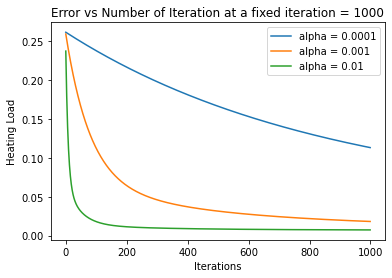

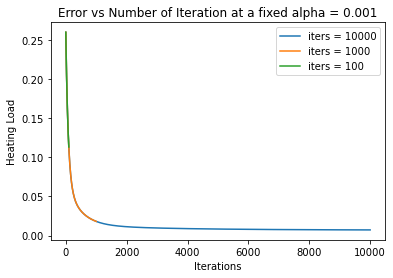

In [19]:
#Hyper-parameters tested
Alpha = [0.0001,0.001,0.01]
Iters = [10000,1000,100]
#Init
ItersF, gitf  = [1 for x in range(len(Alpha)**2)], [1 for x in range(len(Alpha)**2)]

#Create a list in which all the errors and regression matrice at a given iteration and a given alpha are filled
for i,iters in enumerate(Iters):
    for j,alpha in enumerate(Alpha):
        gitf[i*len(Iters)+j] , ItersF[i*len(Iters)+j] = gradientDescent(X_train2,Y_train2,W,iters,alpha)
        
#Plot
for i in range(3):
    plt.plot(np.arange(Iters[1]),ItersF[i+3], label = f'alpha = {Alpha[i]}')
    plt.title('Error vs Number of Iteration at a fixed iteration = 1000')
    plt.xlabel("Iterations")
    plt.ylabel("Heating Load")
    plt.legend()
plt.show()
for i in range(3):
    plt.plot(np.arange(Iters[i]),ItersF[i*3+1],  label = f'iters = {Iters[i]}')
    plt.title('Error vs Number of Iteration at a fixed alpha = 0.001')
    plt.xlabel("Iterations")
    plt.ylabel("Heating Load")
    plt.legend()

Text(0.5, 1.0, 'Final Heating Load Error heatingmap for different alpha and iterations')

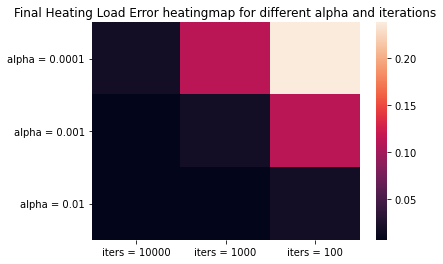

In [20]:
#Final RSS Heating Load values with alpha or iters fixed
HeatingLoad = [computeHeatingLoad(X_train2,Y_train2,g) for g in gitf]
Results = pd.DataFrame(index = [f'alpha = {Alpha[0]}', f'alpha = {Alpha[1]}', f'alpha = {Alpha[2]}'])
#Results['Value of alpha'] = Alpha
for i,iters in enumerate(Iters):
    Results[f'iters = {iters}'] = HeatingLoad[i*3:i*3+3]
sns.heatmap(Results)
plt.title('Final Heating Load Error heatingmap for different alpha and iterations')

The results shows that with our model an important alpha and a large number of iteration fits the best in order to obtain the smallest error.  
However, one can see that at a certain number of iteration or a certain value of alpha chaging the other parameter will not have much consequences.  
Moreover, it is not show here but for values higher than $alpha = 0.32$ the model diverges and cannot reached the minimum point.

### Quantification and visualisation of this linear regression

In this part, we will use the following parameters: $\alpha = 0.01$ and $number \ of \ iteration = 10000$.

  Variable  Coefficient
0       X1    -0.111954
1       X2     0.025165
2       X3     0.165659
3       X4    -0.079606
4       X5     0.455739
5    North     0.003550
6    South     0.001775
7     West     0.003492
8       X7     0.213331
9       X8     0.037117
Mean Squared Error (MSE): 0.006227771238466184
Root Mean Squared Error (RMSE): 0.07891622924637355


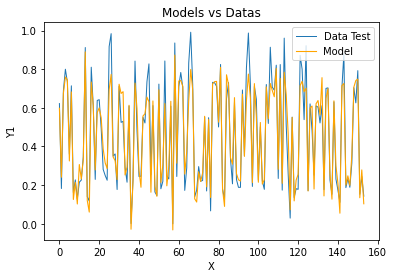

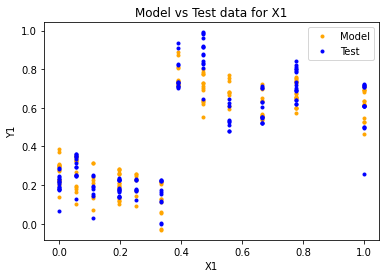

In [21]:
#Weight of the variable in the matrix W
coef_df = pd.DataFrame()
W_new = [W for W in gitf[2]][0]
coef_df['Variable'] = ['X1', 'X2', 'X3', 'X4','X5','North','South','West','X7','X8']
coef_df['Coefficient'] = W_new[1:]
print(coef_df)

Y_pred = X_test2 @ W_new.T
#Calcul of the error over the prediction
# Mean Squared Error (MSE)
MSE=mean_squared_error(Y_test, Y_pred)
print('Mean Squared Error (MSE):',MSE)
# Root Mean Squared Error (RMSE)
print('Root Mean Squared Error (RMSE):',MSE**(1/2))

#Visualization
X_ax=range(len(Y_test))
plt.plot(X_ax,Y_test,linewidth=1,label="Data Test")
plt.plot(X_ax,Y_pred,linewidth=1.1,label="Model",color="orange")
plt.title("Models vs Datas")
plt.legend()
plt.ylabel('Y1')
plt.xlabel('X')
plt.show()

plt.plot(X_test['X1'].to_numpy(),Y_pred,'.',linewidth=1.1,label="Model",color="orange")
plt.plot(X_test['X1'].to_numpy(),Y_test2,'.',linewidth=1.1,label="Test",color="blue")
plt.title("Model vs Test data for X1")
plt.xlabel('X1')
plt.ylabel('Y1')
plt.legend()

The results show that this method can make a relatively good modelisation of Y1 with the explanatory variables.   
Indeed we have a low RMSE with a value of $0.078$.  
However, the different data points where relatively close to each other which can falsify the verification with the test variables.  


## 6) Apply the linear regression of Scikit learn library (cf. the code given in class) + vary attributes and compare to question 5

Jolan

We will still try to do a multilinear regression but using this time the scikit learn library (close to deep learning).  

Coefficient of determination (R2): 0.9148407917294558
       Coefficient
X1       -0.633946
X2       -0.248673
X3        0.019083
X4       -0.346406
X5        0.378803
North     0.003177
South     0.002204
West      0.002505
X7        0.213136
X8        0.036312
Mean Squared Error (MSE): 0.0059378706856328
Root Mean Squared Error (RMSE): 0.07705758032557732


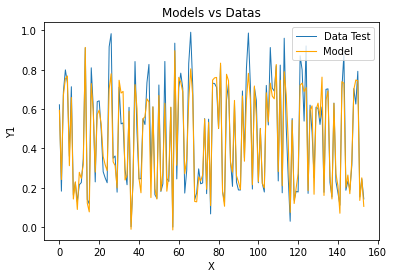

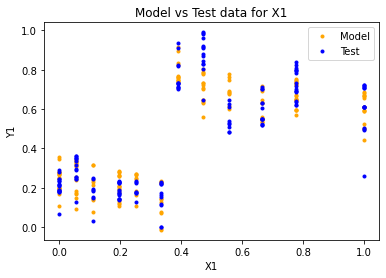

In [23]:
#Definition of the linear regression model
reg = LinearRegression().fit(X_train,Y_train) # adjusted with the train values

print('Coefficient of determination (R2):', reg.score(X_train, Y_train)) #Precision score of the model

#Wheight of the regression
coeff_df2 = pd.DataFrame(reg.coef_, X_shuff.columns, columns=['Coefficient'])
print(coeff_df2) 

# Prediction using the tests
Y_pred = reg.predict(X_test)

#Calcul of the error over the prediction
# Mean Squared Error (MSE)
MSE=mean_squared_error(Y_test, Y_pred)
print('Mean Squared Error (MSE):',MSE)
# Root Mean Squared Error (RMSE)
print('Root Mean Squared Error (RMSE):',MSE**(1/2))



#Visualization 
X_ax=range(len(Y_test))
plt.plot(X_ax,Y_test,linewidth=1,label="Data Test")
plt.plot(X_ax,Y_pred,linewidth=1.1,label="Model",color="orange")
plt.title("Models vs Datas")
plt.legend()
plt.ylabel('Y1')
plt.xlabel('X')
plt.show()

plt.plot(X_test['X1'].to_numpy(),Y_pred,'.',linewidth=1.1,label="Model",color="orange")
plt.plot(X_test['X1'].to_numpy(),Y_test2,'.',linewidth=1.1,label="Test",color="blue")
plt.title("Model vs Test data for X1")
plt.xlabel('X1')
plt.ylabel('Y1')
plt.legend()

### Comparaison

The weights of the different variables is completely different but the results and the exactitude remains the same regarding the value of the RMSE ( 0.078 and 0.083).

## 7) Use python libraries to get p-value of the different coefficients of the variables + Interprete

Mayuxiang

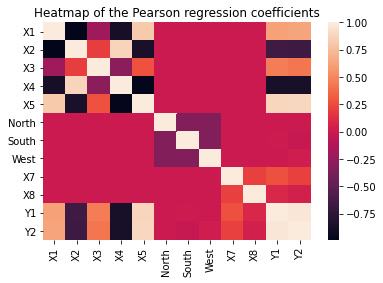

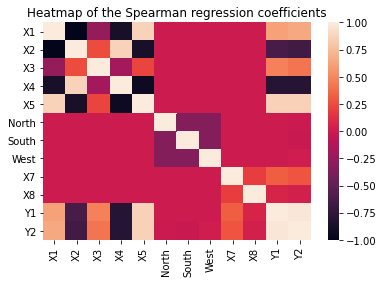

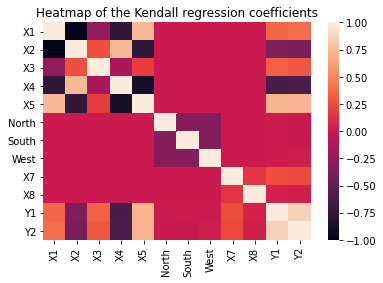

In [24]:
#get all the regression coefficient
corr1 = df_norm.corr(method = 'pearson')
corr2 = df_norm.corr(method = 'spearman')
corr3 = df_norm.corr(method = 'kendall')
sns.heatmap(corr1)
plt.title('Heatmap of the Pearson regression coefficients')
plt.show()
sns.heatmap(corr2)
plt.title('Heatmap of the Spearman regression coefficients')
plt.show()
sns.heatmap(corr3)
plt.title('Heatmap of the Kendall regression coefficients')
plt.show()

Comments

In [25]:
#get all the regression coefficient
corr1, p_value = stats.pearsonr(W_new[1:],reg.coef_)
print(f'PearsonResult : person coefficient = {corr1} and p_value = {p_value}')
corr2, p_value2 = stats.spearmanr(W_new[1:],reg.coef_)
print(f'SpearmanResult : spearman coefficient = {corr2} and p_value = {p_value2}')
corr3, p_value3 = stats.kendalltau(W_new[1:],reg.coef_)
print(f'KendallResult : kendall coefficient = {corr3} and p_value = {p_value3}')


PearsonResult : person coefficient = 0.8257912332795847 and p_value = 0.003246805997856859
SpearmanResult : spearman coefficient = 0.9151515151515152 and p_value = 0.0002044724061488323
KendallResult : kendall coefficient = 0.8222222222222221 and p_value = 0.0003576940035273369


Comments